# About the Data

## Data Quality and Integration Issues

- Inconsistent primary keys across enrollment ranges
- Supabase RLS complications (temporarily disabled)
- Schema naming inconsistencies (for example, `School ID` vs `School_ID`)
- Case-sensitivity issues
- Fragmented time ranges
- Potential duplicate records
- Missing demographic detail
- Inconsistent weapon classification

## Imports and Supabase Connection

In [1]:
import os
import pandas as pd
from supabase import create_client
from dotenv import load_dotenv
from pathlib import Path
import plotly.express as px
%matplotlib inline
# Resolve the project root (one level above `/notebooks`).
project_root = Path.cwd().parent
env_path = project_root / ".env"

load_dotenv(dotenv_path=env_path, override=True)

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)

# Optional sanity check.
print("Loaded key starts with:", SUPABASE_KEY[:5])


Loaded key starts with: eyJhb


## Incident

In [2]:
# Read the incident table in 1,000-row pages to avoid timeouts and memory spikes.
page_size = 1000
# Accumulate rows until Supabase returns an empty page.
all_rows = []
start = 0

while True:
    response = (
        supabase
        .table("incident")
        .select("*")
        .order("Incident_ID")   # Required for stable pagination.
        .range(start, start + page_size - 1)
        .execute()
    )

    data = response.data
    if not data:
        break

    all_rows.extend(data)
    start += page_size

incident_df = pd.DataFrame(all_rows)

# Quick validation of total row count.
print (len(incident_df))
print (incident_df.head(2))

3136
     Incident_ID  Month  Day  Year                       Date  \
0  19660311NCIRC      3   11  1966  1966-03-11T00:00:00+00:00   
1  19660314TXCAW      3   14  1966  1966-03-14T00:00:00+00:00   

                             School Victims_Killed Victims_Wounded  \
0  Irwing Avenue Junior High School              0               1   
1                Carver High School              1               0   

  Number_Victims Shooter_Killed  ... Preplanned SRO_School Security_Screening  \
0              1              0  ...         No                                 
1              1              0  ...         No        Yes       Armed Guards   

      Screening_Outcome Shots_Fired School_Lockdown        LAT         LNG  \
0                                 7                  35.237069  -80.850227   
1  Outside/Off-Property           3                   31.57954  -97.130303   

  Campus_Type Zipcode  
0               28202  
1               76704  

[2 rows x 50 columns]


## Shooter

In [3]:
# Read the shooter table in 1,000-row pages to avoid timeouts and memory spikes.
page_size = 1000
# Accumulate rows until Supabase returns an empty page.
all_rows = []
start = 0

while True:
    response = (
        supabase
        .table("shooter")
        .select("*")
        .order("Incident_ID")   # Required for stable pagination.
        .range(start, start + page_size - 1)
        .execute()
    )

    data = response.data
    if not data:
        break

    all_rows.extend(data)
    start += page_size

shooter_df = pd.DataFrame(all_rows)

# Quick validation of total row count.
print (len(shooter_df))
print (shooter_df.head(2))

3542
  Incident_ID Age Gender Race School_Affiliation Shooter_Outcome Shooter_Died  \
0                                                                               
1                                                                               

  Injury  
0         
1         


## Victim

In [4]:
# Read the victim table in 1,000-row pages to avoid timeouts and memory spikes.
page_size = 1000
# Accumulate rows until Supabase returns an empty page.
all_rows = []
start = 0

while True:
    response = (
        supabase
        .table("victim")
        .select("*")
        .order("Incident_ID")   # Required for stable pagination.
        .range(start, start + page_size - 1)
        .execute()
    )

    data = response.data
    if not data:
        break

    all_rows.extend(data)
    start += page_size

victim_df = pd.DataFrame(all_rows)

# Quick validation of total row count.
print (len(victim_df))
print (victim_df.head(2))

8370
     Incident_ID   Injury Gender School_Affiliation Age   Race
0  19660311NCIRC  Wounded   Male            Student  13    NaN
1  19660314TXCAW    Fatal   Male        No Relation  24  Black


## Weapon

In [5]:
# Read the weapon table in 1,000-row pages to avoid timeouts and memory spikes.
page_size = 1000
# Accumulate rows until Supabase returns an empty page.
all_rows = []
start = 0

while True:
    response = (
        supabase
        .table("weapon")
        .select("*")
        .order("Incident_ID")   # Required for stable pagination.
        .range(start, start + page_size - 1)
        .execute()
    )

    data = response.data
    if not data:
        break

    all_rows.extend(data)
    start += page_size

weapon_df = pd.DataFrame(all_rows)

# Quick validation of total row count.
print (len(weapon_df))
print (weapon_df.head(2))

3168
     Incident_ID Weapon_Type  Weapon_Caliber Weapon_Details
0  19660311NCIRC     Handgun     .22 caliber            NaN
1  19660314TXCAW     Handgun  Service Weapon            NaN


## School Enrollment (1987-2025)

### Enrollment Anomaly Review

#### 1. Anomaly Detected: Structural Break in National Enrollment
- Longitudinal panel constructed for 1987-2025
- Aggregated national enrollment by year
- Abrupt 1.31M drop detected in 2019
- No gradual pre-trend decline
- Observation: pattern is inconsistent with historical trend behavior

#### 2. Diagnostic Investigation
Validation checks performed:
- Year-over-year change analysis
- School counts per year
- Cross-era school-universe comparison

Findings:
- School counts shift by era
- The 2016-2025 era contains fewer schools than prior periods
- Reporting universe is not consistent across datasets

#### 3. Root Cause: NCES Reporting Universe Shift
- Different download templates were used across eras
- Different school-inclusion rules were applied
- Status field availability varied (Open/Closed)
- AE or school-type inclusion may have changed

The 2019 decline reflects a structural reporting shift, not a demographic shock.

#### 4. Corrective Action
- Deleted derived tables
- Re-downloaded all eras using an identical template
- Standardized inclusion rules (for example, open schools only)
- Rebuilt the longitudinal panel with a consistent universe

Result: a comparable enrollment series across the full time span.

This demonstrates:
- Data-validation rigor
- Structural-break detection
- Source-integrity auditing
- Methodological correction

In [6]:
response = (
    supabase
    .table("national_enrollment_trend")
    .select("*")
    .execute()
)

import pandas as pd
df = pd.DataFrame(response.data)

print(df.head())

   year  national_enrollment
0  1987             37195297
1  1988             37755618
2  1989             38278250
3  1990             38858336
4  1991             39738472


### Enrollment Trend Interpretation

- **Strong growth phase (1987-2005):** steady rise from ~37M to ~49M students
- **Plateau period (2006-2019):** enrollment stabilizes around 49-50M
- **Sharp decline (2020-2021):** clear structural break, likely pandemic-driven
- **Partial recovery (2022-2024):** enrollment rebounds but remains below the pre-2020 peak
- **Recent flattening (2024-2025):** slight tapering, possibly demographic contraction

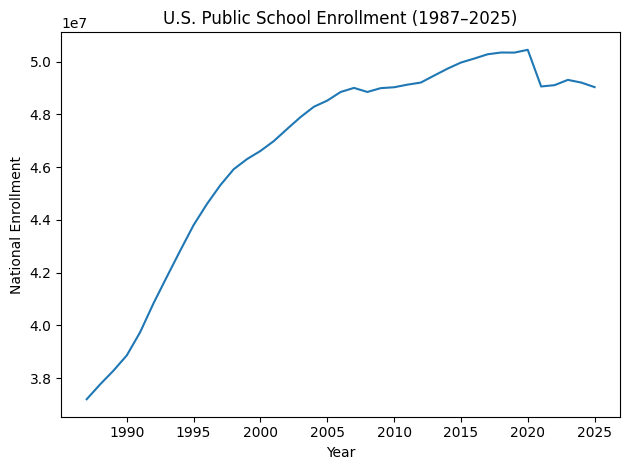

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["year"], df["national_enrollment"])
plt.xlabel("Year")
plt.ylabel("National Enrollment")
plt.title("U.S. Public School Enrollment (1987–2025)")
plt.tight_layout()
plt.show()

### Incident Rate per 100,000 Students

In [8]:
response = (
    supabase
    .table("incident_rate_per_100k")
    .select("*")
    .order("year")
    .execute()
)

import pandas as pd
df = pd.DataFrame(response.data)

print(df.head())
print(df.tail())

   year  incident_count  national_enrollment  incidents_per_100k_students
0  1987              25             37195297                     0.067213
1  1988              38             37755618                     0.100647
2  1989              20             38278250                     0.052249
3  1990              20             38858336                     0.051469
4  1991              32             39738472                     0.080526
    year  incident_count  national_enrollment  incidents_per_100k_students
34  2021             257             49057632                     0.523874
35  2022             308             49106809                     0.627204
36  2023             350             49307936                     0.709825
37  2024             337             49205891                     0.684877
38  2025             146             49033162                     0.297758


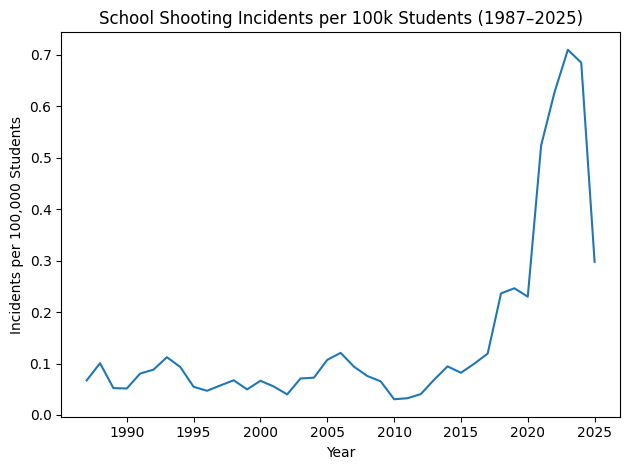

In [9]:
plt.figure()
plt.plot(df["year"], df["incidents_per_100k_students"])
plt.xlabel("Year")
plt.ylabel("Incidents per 100,000 Students")
plt.title("School Shooting Incidents per 100k Students (1987–2025)")
plt.tight_layout()
plt.show()

### Next Analytical Steps

- Overlay shootings trend against enrollment
- Detect structural breaks formally
- Compare pre- and post-2020 risk